In [183]:
#imports

import requests
import time
import string
import unicodedata
import pprint

import pandas as pd

In [184]:
#read in our data
df = pd.read_csv('result_df_july18_1136am.csv')

For this specific subsample example, we need to add back S2 metadata like S2 titles and pubdates (there were left out/removed somehow when this VIAF subsample was created

In [185]:
#for this specific subsample example, we need to add back S2 info like S2 titles and pub dates

#add in the S2 titles

#get publication date to do avergae pub date work
# Load the metadata TSV file into a DataFrame
file_path = 'LitMetadataWithS2 (3).tsv'

import pandas as pd
meta = pd.read_csv(file_path, sep='\t')



In [186]:
# Ensure the authors column is of type list
meta['author'] = meta['authors'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Use the explode method to expand the authors column
meta_exploded = meta.explode('authors')

meta = meta_exploded

# Display the exploded DataFrame
# print(meta_exploded)


In [187]:
import re

def normalize_text(text):
    """
    Normalize the text by converting to lowercase, preserving commas and spaces,
    and removing unnecessary special characters.
    """
    if pd.isna(text):
        return ''
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s,]', '', text)  # Remove all characters except alphanumeric, spaces, and commas
    return text.strip()  # Trim leading and trailing spaces

# title_author_dict = author_titles
# Normalize the dictionary
#normalized_dict = {normalize_text(title): normalize_text(author) for title, author in title_author_dict.items()}
#normalized_dict = {normalize_text(title): normalize_text(author) for title, author in title_author_dict.items()}

# Normalize the DataFrame
# df['normalized_S2_titlelist'] = df['S2_Titlelist'].apply(normalize_text)
# df['normalized_author'] = df['author'].apply(normalize_text)

In [188]:
for idx, row in meta.iterrows():
    author = str(row['author'])
    author_clean = normalize_text(author)
    meta.at[idx, 'author'] = author_clean

Add back the S2 titles

In [189]:
# Initialize an empty dictionary to store the author-title mapping
author_titles = {}

# Iterate over the DataFrame rows
for index, row in meta.iterrows():
    author = str(row['author'])
    title = row['S2titles']
    
    # Use setdefault to initialize the list if the author is not already in the dictionary
    author_titles.setdefault(author, []).append(title)

# # Display the dictionary to verify
# print(author_titles)


In [190]:
title_author_dict = author_titles

df['normalized_author'] = df['author'].apply(normalize_text)


In [191]:
normalized_dict = {normalize_text(str(author)): normalize_text(str(title)) for title, author in author_titles.items()}


In [192]:
swapped_dict = {v: k for k, v in normalized_dict.items()}


In [193]:
# swapped_dict

In [194]:
df['S2_Titlelist'] = df['normalized_author'].map(swapped_dict)


In [195]:
# df

Now add back the S2 pubyears

In [196]:
# Initialize an empty dictionary to store the author-title mapping
author_years = {}

# Iterate over the DataFrame rows
for index, row in meta.iterrows():
    author = str(row['author'])
    year = row['year']
    
    # Use setdefault to initialize the list if the author is not already in the dictionary
    author_years.setdefault(author, []).append(year)

# Display the dictionary to verify
# print(author_titles)


In [197]:
# normalized_dict = {normalize_text(str(author)): normalize_text(str(title)) for title, author in title_author_dict.items()}
normalized_dict = {normalize_text(str(author)): title for title, author in author_years.items()}


In [198]:
#normalize then apply dictionary
# cleaned_dict = {key.strip("[]'"): value for key, value in normalized_dict.items()}
swapped_dict = {v: k for k, v in normalized_dict.items()}


def update_pubdates(name):
    if name in swapped_dict:
        years = swapped_dict[name]
        return years
    
df['S2_pubdates'] = df['normalized_author'].apply(update_pubdates)

In [199]:
# df['S2_pubdates'] = df['author'].map(author_years)

In [200]:
df['S2_pubdates']

0                                                   None
1                                                   None
2                                                   None
3                                                   None
4                                                   None
                             ...                        
806       1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989
807       1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989
808       1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989
809             1994, 1971, 1976, 1987, 1986, 1988, 1993
810    2008, 2014, 2008, 2006, 2015, 2013, 2004, 2003...
Name: S2_pubdates, Length: 811, dtype: object

In [201]:
# df

Step 1: Create the Features We Need

Get all of the necessary information/entries from VIAF
(For the subsample example, this has already been done and can be skipped)

First, set up the functions to search VIAF and intialize the API

In [202]:
def get_name(name):
    params = {
        'query' : f'local.personalNames = "{name}"',
        'maximumRecords': 10,
        'startRecord' : 1,
        'sortKeys': 'holdingscount',
        'httpAccept': 'application/json'
    }

    headers={'User-Agent': user_agent}
    url = "https://viaf.org/viaf/search"

    r = requests.get(url,params=params,headers=headers, timeout=10)
    data = r.json()

    return data

In [203]:
user_agent = 'YOUR PROJECT NAME HERE'
id_column_name = "Name"

pause_between_req = 1

use_title_reconcilation = True

cache = {}

Then create a function to extract the information that we want out of the VIAF JSON returned

In [204]:
# import pandas as pd
# from fuzzywuzzy import fuzz

# birthdates_df = df

# # Function to perform search and return DataFrame with search results
# def search_author(author_name):
#     # Initialize list to store search results
#     search_results = []

#     try:
#         data = get_name(author_name)
#         records = data['searchRetrieveResponse']['records']
#         total_records = len(records)

#         for idx, record in enumerate(records):
#             record_data = record['record']['recordData']
#             birthdate = record['record']['recordData']['birthDate']
#             viaf_title_list = []
#             # Extract titles if available
#             if 'titles' in record_data:
#                 titles_data = record_data['titles']
#                 if titles_data is not None:
#                     if isinstance(titles_data['work'], list):
#                         # Extract titles from the list of works
#                         viaf_title_list.extend([work['title'] for work in titles_data['work'] if 'title' in work])
#                     else:
#                         # Extract title from a single work
#                         title = titles_data['work'].get('title')
#                         if title:
#                             viaf_title_list.append(title)

# #             # Get S2 titles for the author
# #             s2_titles = birthdates_df.loc[birthdates_df['author'] == author_name, 'S2 Titles'].iloc[0]
# #             if isinstance(s2_titles, float):
# #                 s2_titles = []

# #             # Perform fuzzy title matching
# #             title_matched = False
# #             matched_title = None
# #             for title_from_viaf in title_list:
# #                 for s2_title in s2_titles:
# #                     if fuzz.partial_ratio(s2_title, title_from_viaf) >= 70:
# #                         title_matched = True
# #                         matched_title = s2_title
# #                         break
# #                 if title_matched:
# #                     break

# #             # Append author name, title list, S2 titles, title matched, matched title, and birthdate to search results
# #             # birthdate = birthdates_df.loc[birthdates_df['author'] == author_name, 'birthdate'].iloc[0]
# #             search_results.append({'author': author_name, 'record_count': len(records),
# #                                    'record_enumerated': idx, 'title_list': title_list,
# #                                    'S2 Titles': s2_titles, 'title_matched': title_matched,
# #                                    'matched_title': matched_title, 'birthdate': birthdate})
            
#             # Append author name, title list, S2 titles, title matched, matched title, and birthdate to search results
#             # birthdate = birthdates_df.loc[birthdates_df['author'] == author_name, 'birthdate'].iloc[0]
#             title_list = df.loc[df['author'] == author_name, 'title_list'].iloc[0]

#             search_results.append({'author': author_name, 'record_count': len(records),
#                                    'record_enumerated': idx, 'viaf_title_list': viaf_title_list,
#                                    'birthdate': birthdate,'title_list':title_list})
#     except Exception as e:
#         print(f'Processing Error for {author_name}: {e}')

#     return search_results

# # Iterate through each author name in the original DataFrame and perform the search
# all_search_results = []
# row_counter = 0  # Counter to limit the number of rows processed

# for author_name in birthdates_df['author']:
#     search_results = search_author(author_name)
#     all_search_results.extend(search_results)
#     # row_counter += 1
#     # if row_counter >= 5:  # Adjust the number as needed
#     #     break

# # Convert list of dictionaries to DataFrame
# all_search_results_df = pd.DataFrame(all_search_results)
# print(all_search_results_df)


Rename some columns so they match later usage

In [205]:
result_df = df
result_df['VIAF_titlelist'] = result_df['record_enumerated_titles'] 
result_df['S2_titlelist'] = result_df['S2titles']
result_df['average_S2_pubdate'] = result_df['avg_pubdates']
result_df['VIAF_birthdate'] = result_df['standard_birthdate']
result_df['S2_Author'] = result_df['author']


df = result_df

In [206]:
df

,Unnamed: 0,index,author,birthdate,record_enumerated,title_list,record_enumerated_titles,record_count,selected_birthyear,standard_birthdate,...,common_words,notes,normalized_author,S2_Titlelist,S2_pubdates,VIAF_titlelist,S2_titlelist,average_S2_pubdate,VIAF_birthdate,S2_Author
0,0,0,NaN,1869,1,"['All men are brothers', 'All men are brothers...","['All men are brothers', 'All men are brothers...",10,NaN,1869,...,[],NaN,,NaN,None,"['All men are brothers', 'All men are brothers...",[''],NaN,1869,NaN
1,1,1,NaN,1813,2,"['Adagio, clarinet, strings, D♭ major', 'Adieu...","['Adagio, clarinet, strings, D♭ major', 'Adieu...",10,NaN,1813,...,[],NaN,,NaN,None,"['Adagio, clarinet, strings, D♭ major', 'Adieu...",[''],NaN,1813,NaN
2,2,2,NaN,1859,3,"['Adventure of Black Peter', 'Adventure of Bla...","['Adventure of Black Peter', 'Adventure of Bla...",10,NaN,1859,...,[],NaN,,NaN,None,"['Adventure of Black Peter', 'Adventure of Bla...",[''],NaN,1859,NaN
3,3,3,NaN,1866,4,"['10 letters of Sun Yat-Sen, 1914-1916', '30 J...","['10 letters of Sun Yat-Sen, 1914-1916', '30 J...",10,NaN,1866,...,[],NaN,,NaN,None,"['10 letters of Sun Yat-Sen, 1914-1916', '30 J...",[''],NaN,1866,NaN
4,4,4,NaN,1864,5,['Alle guten Wünsche zum neuen Jahre sendet I...,['Alle guten Wünsche zum neuen Jahre sendet I...,10,NaN,1864,...,[],NaN,,NaN,None,['Alle guten Wünsche zum neuen Jahre sendet I...,[''],NaN,1864,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,806,806,Paul Alpers,1941,1,"['1375-1620', '1620-1789', '1789-1888', '476-1...","['1375-1620', '1620-1789', '1789-1888', '476-1...",6,1932.0,1941,...,['modern'],NaN,paul alpers,"convening and convention in pastoral poetry, t...","1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989","['1375-1620', '1620-1789', '1789-1888', '476-1...",['convening and convention in pastoral poetry'...,1984.375000,1941,Paul Alpers
807,807,807,Paul Alpers,1932,2,['Afterlives of Pastoral : in memorian Paul Al...,['Afterlives of Pastoral : in memorian Paul Al...,6,1932.0,1932,...,"['queene', 'poetry', 'pastoral', 'faerie', 'pa...",NaN,paul alpers,"convening and convention in pastoral poetry, t...","1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989",['Afterlives of Pastoral : in memorian Paul Al...,['convening and convention in pastoral poetry'...,1984.375000,1932,Paul Alpers
808,808,808,Paul Alpers,1887,3,"['Alte deutsche Schwänke', 'Celler Flurnamenb...","['Alte deutsche Schwänke', 'Celler Flurnamenb...",6,1932.0,1887,...,[],NaN,paul alpers,"convening and convention in pastoral poetry, t...","1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989","['Alte deutsche Schwänke', 'Celler Flurnamenb...",['convening and convention in pastoral poetry'...,1984.375000,1887,Paul Alpers
809,809,809,Ihab Hassan,1925,1,['Between the Eagle and the Sun : traces of Ja...,['Between the Eagle and the Sun : traces of Ja...,3,1925.0,1925,...,"['literature', 'american', 'criticism', 'postm...",NaN,ihab hassan,criticism in our clime parables of american ac...,"1994, 1971, 1976, 1987, 1986, 1988, 1993",['Between the Eagle and the Sun : traces of Ja...,['criticism in our clime: parables of american...,1985.000000,1925,Ihab Hassan


create our pubage variable

In [207]:
#create our defined function variables
import pandas as pd
import ast
from ast import literal_eval

def find_max_pubdate(pubdates):
    if isinstance(pubdates, list) and all(isinstance(pubdate, int) for pubdate in pubdates):
        return max(pubdates)
    return None

def find_min_pubdate(pubdates):
    if isinstance(pubdates, list) and all(isinstance(pubdate, int) for pubdate in pubdates):
        return min(pubdates)
    return None
    
def find_avg_pubdate(pubdates):
    if isinstance(pubdates, list) and all(isinstance(pubdate, int) for pubdate in pubdates):
        return (sum(pubdates)/len(pubdates))
    return None

def birth2maxdate(birth, pubdates):
        # Convert the string representation to an actual tuple
        # pubdates_tuple = ast.literal_eval(pubdates)
        
        # Check if it's a tuple of integers
        # if isinstance(pubdates_tuple, tuple) and all(isinstance(date, int) for date in pubdates_tuple):
            max_pubdate = find_max_pubdate(pubdates)
            if max_pubdate is not None:
                birth2maxdate = max_pubdate - birth
                abs_birth2maxdate = abs(birth2maxdate)
                return birth2maxdate, abs_birth2maxdate
            return None, None

def birth2mindate(birth, pubdates):
    min_pubdate = find_min_pubdate(pubdates)
    if min_pubdate is not None:
        birth2mindate = min_pubdate - birth
        abs_birth2mindate = abs(birth2mindate)
        return birth2mindate, abs_birth2mindate
    else:
        return None, None

def any_negative(birth2maxdate, birth2mindate):
    if birth2maxdate is not None and birth2mindate is not None:
        if birth2maxdate < 0 or birth2mindate < 0:
            return 1
    return 0

def title_list_len(title_list):
    return len(title_list) if isinstance(title_list, list) else 0

def author_length(author):
    return len(author)

# Master function to process each row
def process_row(row):
    birth = row['VIAF_birthdate']
    pubdates_str = row['S2_pubdates']
    author = str(row['author'])
    
    # if isinstance(pubdates_str, str) and pubdates_str.strip():
    if isinstance(pubdates_str, str):
        try:
            pubdates = ast.literal_eval(pubdates_str)
            if isinstance(pubdates, tuple):
                pubdates = list(pubdates)
        except (SyntaxError, ValueError):
            print(f"Error parsing pubdates_str: {pubdates_str}, Error: {e}")
            pubdates = None
  
    if isinstance(pubdates_str, tuple):
        pubdates = list(pubdates_str)
    elif isinstance(pubdates_str, list):
        pubdates = pubdates_str
    # if pubdates is None:
    #     pubdates = None
    if pubdates_str is None:
        pubdates = None
    
    # if pubdates is None:
    #if pubdates is None or not isinstance(pubdates, list):

        return {
            'birth2maxdate': None,
            'abs_birth2maxdate': None,
            'birth2mindate': None,
            'abs_birth2mindate': None,
            'negative_status': None,
            'title_length': title_list_len(row['S2_Titlelist']),
            'author_length': author_length(author),
            'S2_pubdates': pubdates,
            'birthyear':birth,
            'S2 titlelist':row['S2_Titlelist'],
            'VIAF_titlelist':row['VIAF_titlelist'],
            'selected_birthyear':row['selected_birthyear'],
            'author':row['author']

    }
    birth2maxdate_value, absbirth2maxdate_value = birth2maxdate(birth, pubdates)
    birth2mindate_value, absbirth2mindate_value = birth2mindate(birth, pubdates)
    neg_status = any_negative(birth2maxdate_value, birth2mindate_value)
    title_length = title_list_len(row['S2_Titlelist'])
    author_len = author_length(row['author'])
    avg_pubdate = find_avg_pubdate(pubdates)

    return {
        'birth2maxdate': birth2maxdate_value,
        'abs_birth2maxdate': absbirth2maxdate_value,
        'birth2mindate': birth2mindate_value,
        'abs_birth2mindate': absbirth2mindate_value,
        'negative_status': neg_status,
        'title_length': title_length,
        'author_length': author_len,
        'S2_pubdates': pubdates,
        'birthyear':birth,
        'S2 titlelist':row['S2_Titlelist'],
        'VIAF_titlelist':row['VIAF_titlelist'],
        'selected_birthyear':row['selected_birthyear'],
        'author':row['author']
        


    }

# Assuming df is your DataFrame
df = result_df.apply(process_row, axis=1, result_type='expand')

# Print or use result_df as needed
# print(result_df)


In [208]:
df

,birth2maxdate,abs_birth2maxdate,birth2mindate,abs_birth2mindate,negative_status,title_length,author_length,S2_pubdates,birthyear,S2 titlelist,VIAF_titlelist,selected_birthyear,author
0,NaN,NaN,NaN,NaN,NaN,0,3,None,1869,NaN,"['All men are brothers', 'All men are brothers...",NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0,3,None,1813,NaN,"['Adagio, clarinet, strings, D♭ major', 'Adieu...",NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0,3,None,1859,NaN,"['Adventure of Black Peter', 'Adventure of Bla...",NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0,3,None,1866,NaN,"['10 letters of Sun Yat-Sen, 1914-1916', '30 J...",NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0,3,None,1864,NaN,['Alle guten Wünsche zum neuen Jahre sendet I...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,66.0,66.0,36.0,36.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1941,"convening and convention in pastoral poetry, t...","['1375-1620', '1620-1789', '1789-1888', '476-1...",1932.0,Paul Alpers
807,75.0,75.0,45.0,45.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1932,"convening and convention in pastoral poetry, t...",['Afterlives of Pastoral : in memorian Paul Al...,1932.0,Paul Alpers
808,120.0,120.0,90.0,90.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1887,"convening and convention in pastoral poetry, t...","['Alte deutsche Schwänke', 'Celler Flurnamenb...",1932.0,Paul Alpers
809,69.0,69.0,46.0,46.0,0.0,0,11,"[1994, 1971, 1976, 1987, 1986, 1988, 1993]",1925,criticism in our clime parables of american ac...,['Between the Eagle and the Sun : traces of Ja...,1925.0,Ihab Hassan


In [209]:
df_notnull = df.loc[df['birth2maxdate'].notnull()]

In [210]:
df_notnull

,birth2maxdate,abs_birth2maxdate,birth2mindate,abs_birth2mindate,negative_status,title_length,author_length,S2_pubdates,birthyear,S2 titlelist,VIAF_titlelist,selected_birthyear,author
7,38.0,38.0,-16.0,16.0,1.0,0,16,"[1963, 1962, 1984, 1958, 1986, 1985, 1955, 195...",1950,klopstocks correspondence with albrecht von ha...,"['Alpen', ""Cassell's Deutsch-Englisches, Engli...",NaN,H. T. Betteridge
8,57.0,57.0,27.0,27.0,0.0,0,20,"[1952, 1949, 1930, 1943, 1945, 1932, 1941, 194...",1895,ancient and mediaeval grammatical theory in eu...,['Arthurian legend in the literatures of the s...,1895.0,William J. Entwistle
14,72.0,72.0,42.0,42.0,0.0,0,12,"[1980, 2000, 2009, 1990, 2000, 1985, 1983, 197...",1937,"nan, working with the schools project tempest,...","['Adventures of Huckleberry Finn', 'Beyond the...",[1937],Gerald Graff
15,69.0,69.0,39.0,39.0,0.0,0,17,"[1972, 1971, 1986, 1956, 1974]",1917,rubén darío y la edad media una perspectiva p...,"['Canciones', 'Catch as catch can', 'La Dorote...",[1917],Alan S. Trueblood
23,66.0,66.0,35.0,35.0,0.0,0,14,"[2011, 1981, 2004, 1980, 1999, 1993, 2008]",1945,"sara blair, harlem crossroads black writers an...","['Female subjects in black and white race, psy...",[1945],Elizabeth Abel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,66.0,66.0,36.0,36.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1941,"convening and convention in pastoral poetry, t...","['1375-1620', '1620-1789', '1789-1888', '476-1...",1932.0,Paul Alpers
807,75.0,75.0,45.0,45.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1932,"convening and convention in pastoral poetry, t...",['Afterlives of Pastoral : in memorian Paul Al...,1932.0,Paul Alpers
808,120.0,120.0,90.0,90.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1887,"convening and convention in pastoral poetry, t...","['Alte deutsche Schwänke', 'Celler Flurnamenb...",1932.0,Paul Alpers
809,69.0,69.0,46.0,46.0,0.0,0,11,"[1994, 1971, 1976, 1987, 1986, 1988, 1993]",1925,criticism in our clime parables of american ac...,['Between the Eagle and the Sun : traces of Ja...,1925.0,Ihab Hassan


In [278]:
import pandas as pd
import ast

pubdates_tuple_2 = {}

# Function to compute average publication date
def compute_avg_pubdate(pubdates):
    if pubdates is None:
        return None
    # try:
        # Convert the string representation to an actual tuple
    pubdates_tuple = tuple(pubdates)
    if pubdates_tuple is None:
        return None
    # Check if it's a tuple of integers
    elif isinstance(pubdates_tuple, tuple) and all(isinstance(date, int) for date in pubdates_tuple):
        return sum(pubdates_tuple) / len(pubdates_tuple)
    else:
            for date in pubdates_tuple:
                date = int(date)
                pubdates_tuple_2.add(date)
                return sum(pubdates_tuple) / len(pubdates_tuple)
    # else:
    #     return None
    # # except (ValueError, SyntaxError):
    #     return None

# Apply the function to each row
df['avg_pubdate'] = df['S2_pubdates'].apply(lambda x: compute_avg_pubdate(x))



In [279]:
df_notnull = df.loc[df['avg_pubdate'].notnull()]

In [280]:
df_notnull

,birth2maxdate,abs_birth2maxdate,birth2mindate,abs_birth2mindate,negative_status,title_length,author_length,S2_pubdates,birthyear,S2 titlelist,VIAF_titlelist,selected_birthyear,author,avg_pubdate,publication_age,status,S2_embeddings,VIAF_embeddings,S2_titlelist
7,38.0,38.0,-16.0,16.0,1.0,0,16,"[1963, 1962, 1984, 1958, 1986, 1985, 1955, 195...",1950,klopstocks correspondence with albrecht von ha...,"['Alpen', ""Cassell's Deutsch-Englisches, Engli...",NaN,H. T. Betteridge,1966.586207,NaN,0,"[-0.09977476, 0.040403206, 0.007278494, -0.044...","[-0.027334653, -0.011666706, -0.020841703, -0....",klopstocks correspondence with albrecht von ha...
8,57.0,57.0,27.0,27.0,0.0,0,20,"[1952, 1949, 1930, 1943, 1945, 1932, 1941, 194...",1895,ancient and mediaeval grammatical theory in eu...,['Arthurian legend in the literatures of the s...,1895.0,William J. Entwistle,1939.452174,NaN,0,"[-0.029612226, -0.037666265, 0.017351992, -0.0...","[-0.023454042, -0.05083781, -0.020248184, -0.0...",ancient and mediaeval grammatical theory in eu...
14,72.0,72.0,42.0,42.0,0.0,0,12,"[1980, 2000, 2009, 1990, 2000, 1985, 1983, 197...",1937,"nan, working with the schools project tempest,...","['Adventures of Huckleberry Finn', 'Beyond the...",[1937],Gerald Graff,1991.636364,NaN,0,"[-0.038760673, 0.007519278, 0.040512536, -0.05...","[0.02770838, -0.06463305, -0.011941911, 0.0014...","nan, working with the schools project tempest,..."
15,69.0,69.0,39.0,39.0,0.0,0,17,"[1972, 1971, 1986, 1956, 1974]",1917,rubén darío y la edad media una perspectiva p...,"['Canciones', 'Catch as catch can', 'La Dorote...",[1917],Alan S. Trueblood,1971.800000,NaN,0,"[-0.004974955, 0.018598389, -0.02340891, -0.03...","[0.0018286742, -0.022784166, -0.0023628678, 0....",rubén darío y la edad media una perspectiva p...
23,66.0,66.0,35.0,35.0,0.0,0,14,"[2011, 1981, 2004, 1980, 1999, 1993, 2008]",1945,"sara blair, harlem crossroads black writers an...","['Female subjects in black and white race, psy...",[1945],Elizabeth Abel,1996.571429,NaN,0,"[0.017397633, -0.09652096, -0.018279776, 0.005...","[0.00663707, -0.04953228, 0.005168937, 0.10853...","sara blair, harlem crossroads black writers an..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,66.0,66.0,36.0,36.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1941,"convening and convention in pastoral poetry, t...","['1375-1620', '1620-1789', '1789-1888', '476-1...",1932.0,Paul Alpers,1984.375000,NaN,0,"[0.06421102, -0.008814961, 0.017710868, -0.017...","[-0.109713495, 0.070006244, -0.11301025, 0.041...","convening and convention in pastoral poetry, t..."
807,75.0,75.0,45.0,45.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1932,"convening and convention in pastoral poetry, t...",['Afterlives of Pastoral : in memorian Paul Al...,1932.0,Paul Alpers,1984.375000,NaN,0,"[0.06421102, -0.008814961, 0.017710868, -0.017...","[-0.008266445, 0.020049918, 0.02088213, -0.018...","convening and convention in pastoral poetry, t..."
808,120.0,120.0,90.0,90.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1887,"convening and convention in pastoral poetry, t...","['Alte deutsche Schwänke', 'Celler Flurnamenb...",1932.0,Paul Alpers,1984.375000,NaN,0,"[0.06421102, -0.008814961, 0.017710868, -0.017...","[-0.046454974, 0.09930695, -0.054882158, -0.05...","convening and convention in pastoral poetry, t..."
809,69.0,69.0,46.0,46.0,0.0,0,11,"[1994, 1971, 1976, 1987, 1986, 1988, 1993]",1925,criticism in our clime parables of american ac...,['Between the Eagle and the Sun : traces of Ja...,1925.0,Ihab Hassan,1985.000000,NaN,0,"[0.02483839, -0.022600567, -0.04999136, -0.016...","[-0.0148262875, -0.0067950413, -0.062027816, 0...",criticism in our clime parables of american ac...


In [281]:
#publication_age
df['publication_age'] = df['avg_pubdate'] - df['birthyear']


In [282]:
df

,birth2maxdate,abs_birth2maxdate,birth2mindate,abs_birth2mindate,negative_status,title_length,author_length,S2_pubdates,birthyear,S2 titlelist,VIAF_titlelist,selected_birthyear,author,avg_pubdate,publication_age,status,S2_embeddings,VIAF_embeddings,S2_titlelist
0,NaN,NaN,NaN,NaN,NaN,0,3,None,1869,NaN,"['All men are brothers', 'All men are brothers...",NaN,NaN,NaN,NaN,0,"[-0.11883843, 0.0482987, -0.0025481114, -0.011...","[-0.029320283, 0.0066504637, -0.08198734, 0.02...",NaN
1,NaN,NaN,NaN,NaN,NaN,0,3,None,1813,NaN,"['Adagio, clarinet, strings, D♭ major', 'Adieu...",NaN,NaN,NaN,NaN,0,"[-0.11883843, 0.0482987, -0.0025481114, -0.011...","[-0.052433982, -0.03466971, -0.02602381, -0.01...",NaN
2,NaN,NaN,NaN,NaN,NaN,0,3,None,1859,NaN,"['Adventure of Black Peter', 'Adventure of Bla...",NaN,NaN,NaN,NaN,0,"[-0.11883843, 0.0482987, -0.0025481114, -0.011...","[-0.051208675, -0.047649115, 0.025217777, -0.0...",NaN
3,NaN,NaN,NaN,NaN,NaN,0,3,None,1866,NaN,"['10 letters of Sun Yat-Sen, 1914-1916', '30 J...",NaN,NaN,NaN,NaN,0,"[-0.11883843, 0.0482987, -0.0025481114, -0.011...","[-0.11284647, 0.054138478, 0.025148952, -0.009...",NaN
4,NaN,NaN,NaN,NaN,NaN,0,3,None,1864,NaN,['Alle guten Wünsche zum neuen Jahre sendet I...,NaN,NaN,NaN,NaN,0,"[-0.11883843, 0.0482987, -0.0025481114, -0.011...","[-0.09869104, 0.093701385, 0.023673616, 0.0290...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,66.0,66.0,36.0,36.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1941,"convening and convention in pastoral poetry, t...","['1375-1620', '1620-1789', '1789-1888', '476-1...",1932.0,Paul Alpers,1984.375000,43.375000,0,"[0.06421102, -0.008814961, 0.017710868, -0.017...","[-0.109713495, 0.070006244, -0.11301025, 0.041...","convening and convention in pastoral poetry, t..."
807,75.0,75.0,45.0,45.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1932,"convening and convention in pastoral poetry, t...",['Afterlives of Pastoral : in memorian Paul Al...,1932.0,Paul Alpers,1984.375000,52.375000,0,"[0.06421102, -0.008814961, 0.017710868, -0.017...","[-0.008266445, 0.020049918, 0.02088213, -0.018...","convening and convention in pastoral poetry, t..."
808,120.0,120.0,90.0,90.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1887,"convening and convention in pastoral poetry, t...","['Alte deutsche Schwänke', 'Celler Flurnamenb...",1932.0,Paul Alpers,1984.375000,97.375000,0,"[0.06421102, -0.008814961, 0.017710868, -0.017...","[-0.046454974, 0.09930695, -0.054882158, -0.05...","convening and convention in pastoral poetry, t..."
809,69.0,69.0,46.0,46.0,0.0,0,11,"[1994, 1971, 1976, 1987, 1986, 1988, 1993]",1925,criticism in our clime parables of american ac...,['Between the Eagle and the Sun : traces of Ja...,1925.0,Ihab Hassan,1985.000000,60.000000,0,"[0.02483839, -0.022600567, -0.04999136, -0.016...","[-0.0148262875, -0.0067950413, -0.062027816, 0...",criticism in our clime parables of american ac...


In [283]:
df['publication_age'] = pd.to_numeric(df['publication_age'], errors='coerce')


Add status variable, and then convert it from string to numbers

In [366]:
df['status'] = ""

for idx, row in df.iterrows():
    if row['publication_age'] < 0:
        df.at[idx,'status'] = 'not_born'
    elif row['publication_age'] > 100:
        df.at[idx,'status'] = 'zombie'
    elif row['publication_age'] < 9:
        df.at[idx,'status'] = 'toddler'
    else:
        df.at[idx,'status'] = '0'



In [285]:
df.loc[df['status'] != '0']

,birth2maxdate,abs_birth2maxdate,birth2mindate,abs_birth2mindate,negative_status,title_length,author_length,S2_pubdates,birthyear,S2 titlelist,VIAF_titlelist,selected_birthyear,author,avg_pubdate,publication_age,status,S2_embeddings,VIAF_embeddings,S2_titlelist
27,173.0,173.0,156.0,156.0,0.0,0,11,"[1995, 1999, 2008, 1994, 1993, 1991]",1835,"social comedy in austria and germany 18901933,...","['Ballads and metrical sketches, 1860:', 'The ...",NaN,John Warren,1996.666667,161.666667,zombie,"[0.012772598, 0.022973368, -0.042786438, -0.01...","[-0.046514235, 0.033876326, 0.018255588, -0.03...","social comedy in austria and germany 18901933,..."
42,132.0,132.0,86.0,86.0,0.0,0,12,"[1960, 1953, 1982, 1988, 1968, 1952, 1986, 198...",1861,torcimany de luis de averco tratado retorico g...,['The genitalia of the group Noctuidæ ... 1909...,1915.0,Frank Pierce,1972.416667,111.416667,zombie,"[-0.029248776, 0.013883111, -0.0037894442, -0....","[0.019211646, 0.0534619, -0.0058466117, -0.010...",torcimany de luis de averco tratado retorico g...
43,138.0,138.0,92.0,92.0,0.0,0,12,"[1960, 1953, 1982, 1988, 1968, 1952, 1986, 198...",1855,torcimany de luis de averco tratado retorico g...,"['Address of the president:', 'American plays ...",1915.0,Frank Pierce,1972.416667,117.416667,zombie,"[-0.029248776, 0.013883111, -0.0037894442, -0....","[-0.048686232, 0.006816469, 0.008048234, -0.02...",torcimany de luis de averco tratado retorico g...
45,152.0,152.0,106.0,106.0,0.0,0,12,"[1960, 1953, 1982, 1988, 1968, 1952, 1986, 198...",1841,torcimany de luis de averco tratado retorico g...,"[""Appletons' medical dictionary; an illustrate...",1915.0,Frank Pierce,1972.416667,131.416667,zombie,"[-0.029248776, 0.013883111, -0.0037894442, -0....","[0.016684417, -0.009492612, -0.03989831, -0.05...",torcimany de luis de averco tratado retorico g...
47,125.0,125.0,79.0,79.0,0.0,0,12,"[1960, 1953, 1982, 1988, 1968, 1952, 1986, 198...",1868,torcimany de luis de averco tratado retorico g...,[],1915.0,Frank Pierce,1972.416667,104.416667,zombie,"[-0.029248776, 0.013883111, -0.0037894442, -0....","[-0.06406342, -0.0068996744, 0.04437984, -0.04...",torcimany de luis de averco tratado retorico g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,176.0,176.0,121.0,121.0,0.0,0,18,"[1950, 1941, 1961, 1949, 1945, 1943, 1947, 194...",1815,the four brontes the lives and works of charlo...,"['Aaron Trow', 'The American senator', 'Austra...",1906.0,Kathleen Tillotson,1946.948276,131.948276,zombie,"[-0.03545653, -0.043389786, -0.03159657, -0.07...","[-0.042055003, -0.041893665, 0.0236411, 0.0067...",the four brontes the lives and works of charlo...
758,144.0,144.0,129.0,129.0,0.0,0,13,"[2000, 2004, 2006, 2011, 2015, 2009, 2011, 200...",1871,dramaturgies of sprachkritik rainer werner fas...,['Alphabetical guide to Sinhalese folklore fro...,1968.0,David Barnett,2007.666667,136.666667,zombie,"[-0.00443278, -0.05186151, -0.03281609, -0.056...","[-0.031011077, -0.0020670642, -0.07741134, -0....",dramaturgies of sprachkritik rainer werner fas...
761,108.0,108.0,93.0,93.0,0.0,0,13,"[2000, 2004, 2006, 2011, 2015, 2009, 2011, 200...",1907,dramaturgies of sprachkritik rainer werner fas...,"['Air, flute, harp', 'Balladen Viola Klavier o...",1968.0,David Barnett,2007.666667,100.666667,zombie,"[-0.00443278, -0.05186151, -0.03281609, -0.056...","[-0.04543552, -0.06794054, 0.023011599, -0.015...",dramaturgies of sprachkritik rainer werner fas...
769,155.0,155.0,132.0,132.0,0.0,0,15,"[1910, 1926, 1920, 1907, 1915, 1907, 1916, 191...",1771,"elckerlijceveryman the question of priority, s...",[],1859.0,Francis A. Wood,1913.705882,142.705882,zombie,"[-0.0042206747, -0.12663548, 0.05198935, -0.03...","[-0.06406342, -0.0068996744, 0.04437984, -0.04...","elckerlijceveryman the question of priority, s..."


In [286]:
df['status'] = df['status'].str.replace('zombie', '1')
df['status'] = df['status'].fillna('0')
df['status'] = df['status'].str.replace('not_born', '2')
df['status'] = df['status'].str.replace('toddler', '3')


In [287]:
# df.loc[df['status'] == '2']

Now S2 and VIAF titlelist embeddings

In [365]:
#embeddings

from sentence_transformers import SentenceTransformer

# Load the pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to generate embeddings for a list of titles
def get_embeddings(titles_list):
    if isinstance(titles_list, str):
        return model.encode(titles_list)
    else:
        return model.encode('')

# Generate embeddings for each row in the DataFrame
df['S2_embeddings'] = df['S2 titlelist'].apply(get_embeddings)
df['VIAF_embeddings'] = df['VIAF_titlelist'].apply(get_embeddings)

KeyboardInterrupt: 

In [289]:
df['S2_titlelist'] = df['S2 titlelist']

In [290]:
# #parse embeddings
# #fix embedding issue like we determined in earlier notebook:
# import numpy as np
# import ast

# def parse_embedding(embedding_str):
#     try:
#         # Remove leading and trailing brackets
#         # embedding_str = embedding_str.strip('[]')
        
#         # Replace newlines with spaces and split by spaces
#         # embedding_list = embedding_str.replace('\n', ' ').split()
        
#         # Convert list to numpy array
#         return np.array([float(x) for x in embedding_list], dtype=np.float32)
#     except ValueError as e:
#         print(f"Error parsing embedding: {e}")
#         return np.array([])  # return an empty array in case of error


# df['S2_embeddings_array'] = df['S2_embeddings'].apply(parse_embedding)
# df['VIAF_embeddings_array'] = df['VIAF_embeddings'].apply(parse_embedding)


#I think this step isn't needed since the embeddings WERE created within this notebook



In [292]:
import numpy as np
df['S2_embeddings'] = df['S2_embeddings'].apply(np.mean)
df['VIAF_embeddings'] = df['VIAF_embeddings'].apply(np.mean)

In [295]:
#get overlapping words and overlapping lemmas:
# Function to lemmatize text and return a set of lemmatized words
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return set(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

# Function to calculate lemma overlap and return the overlapping lemmas
def calculate_lemma_overlap(text1, text2):
    text1 = str(text1)
    text2 = str(text2)
    lemmas1 = lemmatize_text(text1)
    lemmas2 = lemmatize_text(text2)
    overlap = lemmas1.intersection(lemmas2)
    return len(overlap), overlap

# # Apply the function to compute lemma overlap for each row in the DataFrame
# df[['lemma_overlap', 'overlapping_lemmas']] = df.apply(
#     lambda row: pd.Series(calculate_lemma_overlap(row['VIAF_titlelist'], row['S2_titlelist'])), 
#     axis=1)
df[['lemma_overlap', 'overlapping_lemmas']] = df.apply(
    lambda row: pd.Series(calculate_lemma_overlap(row['VIAF_titlelist'], row['S2_titlelist'])), 
    axis=1)


In [355]:
#add overlaps

#add word overlap as a new feature
import pandas as pd
from nltk.corpus import stopwords
import nltk

# Download stopwords from NLTK if you haven't already
nltk.download('stopwords')
# Define stop words
stop_words = set(stopwords.words('english'))

# Function to create bag of words after removing stop words
def bag_of_words(title):
    words = title.lower().split()
    return set([word for word in words if word not in stop_words])

# Function to find and count word overlap
def find_word_overlap(row):
    # try:
            if not pd.isna(row['VIAF_titlelist']) and not pd.isna(row['S2_titlelist']):
                v_list = ast.literal_eval((row['VIAF_titlelist']))
                s_list = ast.literal_eval((row['S2_titlelist']))
                if isinstance(v_list, list):
        
                    for title in v_list:
                        title = str(title)
                if isinstance(s_list, list):
        
                    for title in s_list:
                        title = str(title)
                if isinstance(v_list, list):
        
                    v_bag = bag_of_words(v_list) 
                if isinstance(s_list, list):
        
                    s_bag = bag_of_words(s_list) 
        
                    overlap = v_bag & s_bag
            else:
                overlap = ''
            # except:
            #     overlap = ''
            return pd.Series([len(overlap), list(overlap)])
      
  
# Apply the function to each row and create two new columns
df[['word_overlap_count', 'overlapping_words']] = df.apply(find_word_overlap, axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beccacohen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SyntaxError: invalid syntax (<unknown>, line 1)

In [363]:
import pandas as pd
import ast
from nltk.corpus import stopwords
import nltk

#Jaccard index
#add cosine distance column

# Download stopwords from NLTK if you haven't already
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to create bag of words after removing stop words
def bag_of_words(title):
    words = title.lower().split()
    return set([word for word in words if word not in stop_words])

# Function to find and count word overlap
def find_word_overlap(row):
    if not pd.isna(row['VIAF_titlelist']) and not pd.isna(row['S2_titlelist']):
        try:
            # Convert string representations to lists using ast.literal_eval
            v_list = ast.literal_eval(row['VIAF_titlelist'])
            s_list = ast.literal_eval(row['S2_titlelist'])
            
            # Initialize sets for storing bag of words
            v_bag = set()
            s_bag = set()

            # Create bag of words for VIAF titles
            if isinstance(v_list, list):
                for title in v_list:
                    title = str(title)
                    v_bag.update(bag_of_words(title))  # Update the set with words

            # Create bag of words for S2 titles
            if isinstance(s_list, list):
                for title in s_list:
                    title = str(title)
                    s_bag.update(bag_of_words(title))  # Update the set with words

            # Find overlap between the two sets of words
            overlap = v_bag & s_bag
        except (ValueError, SyntaxError):
            overlap = set()  # In case of any parsing error
    else:
        overlap = set()  # If either list is missing

    # Return the overlap count and the list of overlapping words
    return pd.Series([len(overlap), list(overlap)])

# Apply the function to each row and create two new columns
df[['word_overlap_count', 'overlapping_words']] = df.apply(find_word_overlap, axis=1)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beccacohen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [362]:
df['word_overlap_count']

0      0
1      0
2      0
3      0
4      0
      ..
806    0
807    0
808    0
809    0
810    0
Name: word_overlap_count, Length: 811, dtype: int64

In [299]:
#embed overlapping word meaning
import spacy
import numpy as np

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def get_word_embeddings(words):
    embeddings = [nlp(word).vector for word in words if nlp(word).has_vector]
    if not embeddings:  # Handle case where no valid embeddings
        return np.zeros(nlp.vocab.vectors.shape[1])
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding


df['mean_embedding'] = df['overlapping_words'].apply(get_word_embeddings)


In [297]:
#rename to keep track of where birthdate data came from
df['VIAF_birthdate'] = df['birthyear']
df['pub_age'] = df['publication_age']

In [298]:
#store the metadata to examine later with the probabilities
original_indices = df.index
original_metadata = df[['VIAF_titlelist', 'selected_birthyear', 'author', 'S2_titlelist','status','pub_age','avg_pubdate', 'VIAF_birthdate','overlapping_words','word_overlap_count','lemma_overlap','overlapping_lemmas']].copy()




In [300]:
df['status'] = df['status'].apply(pd.to_numeric)


In [301]:
df

,birth2maxdate,abs_birth2maxdate,birth2mindate,abs_birth2mindate,negative_status,title_length,author_length,S2_pubdates,birthyear,S2 titlelist,...,S2_embeddings,VIAF_embeddings,S2_titlelist,lemma_overlap,overlapping_lemmas,word_overlap_count,overlapping_words,VIAF_birthdate,pub_age,mean_embedding
0,NaN,NaN,NaN,NaN,NaN,0,3,None,1869,NaN,...,0.001638,-0.001305,NaN,0,{},0,[],1869,NaN,[]
1,NaN,NaN,NaN,NaN,NaN,0,3,None,1813,NaN,...,0.001638,-0.000812,NaN,0,{},0,[],1813,NaN,[]
2,NaN,NaN,NaN,NaN,NaN,0,3,None,1859,NaN,...,0.001638,-0.000511,NaN,0,{},0,[],1859,NaN,[]
3,NaN,NaN,NaN,NaN,NaN,0,3,None,1866,NaN,...,0.001638,-0.001297,NaN,0,{},0,[],1866,NaN,[]
4,NaN,NaN,NaN,NaN,NaN,0,3,None,1864,NaN,...,0.001638,-0.001834,NaN,0,{},0,[],1864,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,66.0,66.0,36.0,36.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1941,"convening and convention in pastoral poetry, t...",...,-0.000664,-0.001304,"convening and convention in pastoral poetry, t...",1,{modern},0,[],1941,43.375000,[]
807,75.0,75.0,45.0,45.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1932,"convening and convention in pastoral poetry, t...",...,-0.000664,-0.001322,"convening and convention in pastoral poetry, t...",3,"{queene, pastoral, poetry}",0,[],1932,52.375000,[]
808,120.0,120.0,90.0,90.0,0.0,0,11,"[1983, 1977, 1977, 1978, 1982, 1982, 2007, 1989]",1887,"convening and convention in pastoral poetry, t...",...,-0.000664,-0.001751,"convening and convention in pastoral poetry, t...",0,{},0,[],1887,97.375000,[]
809,69.0,69.0,46.0,46.0,0.0,0,11,"[1994, 1971, 1976, 1987, 1986, 1988, 1993]",1925,criticism in our clime parables of american ac...,...,-0.000870,-0.001676,criticism in our clime parables of american ac...,5,"{criticism, perspective, literature, american,...",0,[],1925,60.000000,[]


In [303]:
#in this case, I had done the true labels by hand, so let's add them in here
df_2 = pd.read_csv('new_labels_aug22.csv')
df['match?'] = df_2['new_label']

In [304]:
df_2

,Column1,VIAF_titlelist,author,S2_titlelist,status,pub_age,avg_pubdates,standard_birthdate_viaf,overlapping_words,overlapping_lemmas,Class_0_Proba,Class_1_Proba,Class_Decision,True_Label,label_match?,Column2,Column3,new_label
0,0,"['All men are brothers', 'All men are brothers...",NaN,[''],0,NaN,NaN,1869,[],set(),0.84,0.16,0,0,True,NaN,NaN,0
1,1,"['Adagio, clarinet, strings, D♭ major', 'Adieu...",NaN,[''],0,NaN,NaN,1813,[],set(),0.82,0.18,0,0,True,NaN,NaN,0
2,2,"['Adventure of Black Peter', 'Adventure of Bla...",NaN,[''],0,NaN,NaN,1859,[],set(),0.83,0.17,0,0,True,NaN,NaN,0
3,3,"['10 letters of Sun Yat-Sen, 1914-1916', '30 J...",NaN,[''],0,NaN,NaN,1866,[],set(),0.82,0.18,0,0,True,NaN,NaN,0
4,4,['Alle guten Wünsche zum neuen Jahre sendet I...,NaN,[''],0,NaN,NaN,1864,[],set(),0.83,0.17,0,0,True,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,806,"['1375-1620', '1620-1789', '1789-1888', '476-1...",paul alpers,['convening and convention in pastoral poetry'...,0,43.0,1984.375000,1941,"[""'what"", 'modern', ""'the""]",{'modern'},0.31,0.69,0,0,True,NaN,NaN,0
807,807,['Afterlives of Pastoral : in memorian Paul Al...,paul alpers,['convening and convention in pastoral poetry'...,0,52.0,1984.375000,1932,"['pastoral', ""'what"", 'faerie', ""queene',"", ""'...","{'poetry', 'pastoral', 'queene'}",0.19,0.81,1,1,True,NaN,NaN,1
808,808,"['Alte deutsche Schwänke', 'Celler Flurnamenb...",paul alpers,['convening and convention in pastoral poetry'...,0,97.0,1984.375000,1887,[],set(),0.35,0.65,0,0,True,NaN,NaN,0
809,809,['Between the Eagle and the Sun : traces of Ja...,NaN,['criticism in our clime: parables of american...,0,60.0,1985.000000,1925,"['postmodern', 'american']","{'postmodern', 'literature', 'american', 'pers...",0.24,0.76,1,1,True,NaN,NaN,1


In [306]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_recall_curve, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, accuracy_score)
import matplotlib.pyplot as plt


# X = df.drop(columns=['author','VIAF_titlelist','S2_titlelist','overlapping_words','selected_birthyear','overlapping_lemmas','mean_embedding','matched_title?','match','match?','title_list','record_enumerated_titles','S2titles','matched_title_list','normalized_author','common_words','S2_Author','notes','S2_pubdates','S2_Titlelist','selected_birthyear'])  # Drop the label and metadata columns

X = df.drop(columns=['author','VIAF_titlelist','S2_titlelist','overlapping_words','selected_birthyear','overlapping_lemmas','mean_embedding','match?','S2_pubdates','selected_birthyear','negative_status', 'S2 titlelist'])
y = df['match?']

# Optional: If you want to split into training and test sets first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [307]:
 # df[['birthdate','standard_birthdate','VIAF_birthdate']]

In [308]:
# For DataFrames and Series, you can also check the data types of columns
print("\nData types in X_train:")
print(X_train.dtypes)
print("\nData types in y_train:")
print(y_train.dtype)


Data types in X_train:
birth2maxdate         float64
abs_birth2maxdate     float64
birth2mindate         float64
abs_birth2mindate     float64
title_length            int64
author_length           int64
birthyear               int64
avg_pubdate           float64
publication_age       float64
status                  int64
S2_embeddings         float32
VIAF_embeddings       float32
lemma_overlap           int64
word_overlap_count      int64
VIAF_birthdate          int64
pub_age               float64
dtype: object

Data types in y_train:
int64


In [309]:



X['birth2mindate'] = pd.to_numeric(X['birth2mindate'], errors= 'coerce')
X['birth2maxdate'] = pd.to_numeric(X['birth2maxdate'], errors= 'coerce')

X['abs_birth2mindate'] = pd.to_numeric(X['abs_birth2mindate'], errors= 'coerce')

X['abs_birth2maxdate'] = pd.to_numeric(X['abs_birth2maxdate'], errors= 'coerce')


In [310]:
pd.to_numeric(X['birth2mindate'], errors= 'coerce')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
806    36.0
807    45.0
808    90.0
809    46.0
810    37.0
Name: birth2mindate, Length: 811, dtype: float64

In [311]:
pd.to_numeric(X['birth2mindate'], errors= 'coerce')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
806    36.0
807    45.0
808    90.0
809    46.0
810    37.0
Name: birth2mindate, Length: 811, dtype: float64

In [312]:
print(X)

     birth2maxdate  abs_birth2maxdate  birth2mindate  abs_birth2mindate  \
0              NaN                NaN            NaN                NaN   
1              NaN                NaN            NaN                NaN   
2              NaN                NaN            NaN                NaN   
3              NaN                NaN            NaN                NaN   
4              NaN                NaN            NaN                NaN   
..             ...                ...            ...                ...   
806           66.0               66.0           36.0               36.0   
807           75.0               75.0           45.0               45.0   
808          120.0              120.0           90.0               90.0   
809           69.0               69.0           46.0               46.0   
810           50.0               50.0           37.0               37.0   

     title_length  author_length  birthyear  avg_pubdate  publication_age  \
0               0     

In [313]:
# For DataFrames and Series, you can also check the data types of columns
print("\nData types in X:")
print(X.dtypes)
print("\nData types in y:")
print(y.dtype)


Data types in X:
birth2maxdate         float64
abs_birth2maxdate     float64
birth2mindate         float64
abs_birth2mindate     float64
title_length            int64
author_length           int64
birthyear               int64
avg_pubdate           float64
publication_age       float64
status                  int64
S2_embeddings         float32
VIAF_embeddings       float32
lemma_overlap           int64
word_overlap_count      int64
VIAF_birthdate          int64
pub_age               float64
dtype: object

Data types in y:
int64


In [314]:
#filter methods of feature selection
#correlations
corr_matrix = X.corr()  # Default is Pearson correlation




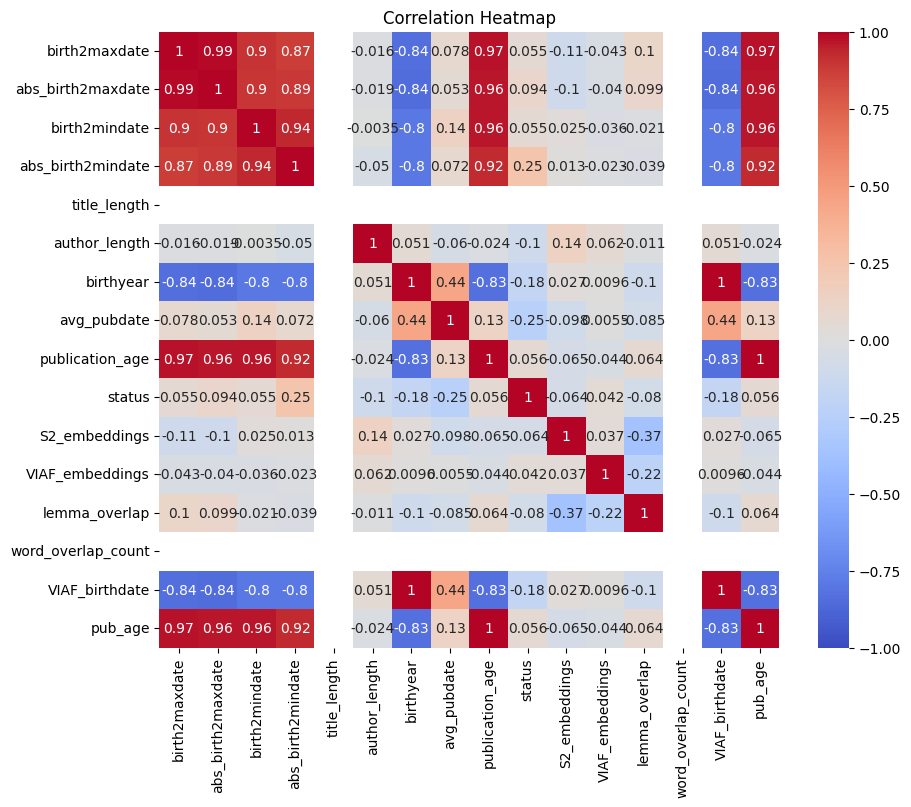

In [316]:
import seaborn as sns
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [317]:
# #coefficents
# print(model.intercept_,model.coef_)


In [318]:
type(X)

pandas.core.frame.DataFrame

In [319]:
X.dtypes


birth2maxdate         float64
abs_birth2maxdate     float64
birth2mindate         float64
abs_birth2mindate     float64
title_length            int64
author_length           int64
birthyear               int64
avg_pubdate           float64
publication_age       float64
status                  int64
S2_embeddings         float32
VIAF_embeddings       float32
lemma_overlap           int64
word_overlap_count      int64
VIAF_birthdate          int64
pub_age               float64
dtype: object

In [320]:
# #threshold variance
# import pandas as pd
# from sklearn.feature_selection import VarianceThreshold
# 
# # Convert DataFrame to NumPy array
# # X = X.values
# # Initialize VarianceThreshold, threshold can be customized (e.g., 0.1 or 0.5)
# threshold = 0.1
# selector = VarianceThreshold(threshold=threshold)
# 
# # Apply the variance threshold
# X_reduced = selector.fit_transform(X)
# 
# # Get the names of the remaining features
# remaining_features = df.columns[selector.get_support()]
# 
# # Convert the reduced data back to a DataFrame with the selected features
# df_reduced = pd.DataFrame(X_reduced, columns=remaining_features)
# 
# print("Original Features:\n", df)
# print("\nSelected Features (with variance threshold = {}):\n".format(threshold), df_reduced)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 16

In [321]:
# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')

# Perform cross-validation
# model = RandomForestClassifier()


In [322]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from sklearn.datasets import make_regression
# 
# # Create a sample dataset (or load your dataset)
# X, y = make_regression(n_samples=100, n_features=10, noise=0.1)
# df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])
# df['Target'] = y
# 
# # Forward Selection Function
# def forward_selection(data, target):
#     initial_features = []
#     best_features = initial_features.copy()
#     while True:
#         remaining_features = list(set(data.columns) - set(best_features))
#         best_pval = float('inf')
#         best_feature = None
#         
#         for feature in remaining_features:
#             model = sm.OLS(data[target], sm.add_constant(data[best_features + [feature]])).fit()
#             pval = model.pvalues[feature]
#             if pval < best_pval:
#                 best_pval = pval
#                 best_feature = feature
#                 
#         if best_pval < 0.05:  # Adjust p-value threshold as needed
#             best_features.append(best_feature)
#         else:
#             break
#             
#     return best_features
# 
# # Backward Selection Function
# def backward_selection(data, target):
#     features = data.columns.tolist()
#     while True:
#         model = sm.OLS(data[target], sm.add_constant(data[features])).fit()
#         pvals = model.pvalues.iloc[1:]  # Exclude the intercept
#         worst_pval = pvals.max()
#         
#         if worst_pval >= 0.05:  # Adjust p-value threshold as needed
#             worst_feature = pvals.idxmax()
#             features.remove(worst_feature)
#         else:
#             break
#             
#     return features
# 
# # Applying Forward Selection
# forward_selected_features = forward_selection(df.drop(columns='Target'), 'Target')
# print("Forward Selected Features:", forward_selected_features)
# 
# # Applying Backward Selection
# backward_selected_features = backward_selection(df.drop(columns='Target'), 'Target')
# print("Backward Selected Features:", backward_selected_features)


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
#forward and backwards selectio nmethods 

In [323]:
y_pred_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')

# Store predictions with original indices
predictions_df = pd.DataFrame(y_pred_proba, index=original_indices, columns=['Class_0_Proba', 'Class_1_Proba'])

# Merge the metadata back
results_df = pd.concat([original_metadata, predictions_df], axis=1)
results_df['True_Label'] = y.loc[results_df.index]

# Now you have a DataFrame with metadata and predictions
print(results_df.head())

                                      VIAF_titlelist selected_birthyear  \
0  ['All men are brothers', 'All men are brothers...                NaN   
1  ['Adagio, clarinet, strings, D♭ major', 'Adieu...                NaN   
2  ['Adventure of Black Peter', 'Adventure of Bla...                NaN   
3  ['10 letters of Sun Yat-Sen, 1914-1916', '30 J...                NaN   
4  ['Alle guten Wünsche zum neuen Jahre sendet I...                NaN   

  author S2_titlelist status  pub_age  avg_pubdate  VIAF_birthdate  \
0    NaN          NaN      0      NaN          NaN            1869   
1    NaN          NaN      0      NaN          NaN            1813   
2    NaN          NaN      0      NaN          NaN            1859   
3    NaN          NaN      0      NaN          NaN            1866   
4    NaN          NaN      0      NaN          NaN            1864   

  overlapping_words  word_overlap_count  lemma_overlap overlapping_lemmas  \
0                []                   0            

In [472]:
# y_pred_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')
# 
# # Store predictions with original indices
# predictions_df = pd.DataFrame(y_pred_proba, index=original_indices, columns=['Class_0_Proba', 'Class_1_Proba'])
# 
# # Merge the metadata back
# results_df = pd.concat([original_metadata, predictions_df], axis=1)
# results_df['True_Label'] = y.loc[results_df.index]
# 
# # Now you have a DataFrame with metadata and predictions
# print(results_df.head())

In [395]:
# #including the testing and training sets
# 
# predictions_df = pd.DataFrame(y_pred_proba, index=X_train.index, columns=['Class_0_Proba', 'Class_1_Proba'])
# 
# # Merge the metadata with predictions using original indices
# results_df = pd.concat([original_metadata.loc[X_train.index], predictions_df], axis=1)
# 
# # Add the true labels to the DataFrame
# results_df['True_Label'] = y_train
# 
# # Display the first few rows of the DataFrame
# print(results_df.head())


In [396]:
# from sklearn.metrics import classification_report
# 
# # Convert predicted probabilities to class labels (0 or 1 based on threshold 0.5)
# y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)
# 
# 
# # Generate classification report based on the true labels (y_train) and predicted labels (y_pred)
# report = classification_report(y_train, y_pred)
# 
# # Print the classification report
# print(report)

In [324]:
#all data included

y_pred_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')

# Store predictions with original indices
predictions_df = pd.DataFrame(y_pred_proba, index=original_indices, columns=['Class_0_Proba', 'Class_1_Proba'])

# Merge the metadata back
results_df = pd.concat([original_metadata, predictions_df], axis=1)
results_df['True_Label'] = y.loc[results_df.index]

# Now you have a DataFrame with metadata and predictions
print(results_df.head())

                                      VIAF_titlelist selected_birthyear  \
0  ['All men are brothers', 'All men are brothers...                NaN   
1  ['Adagio, clarinet, strings, D♭ major', 'Adieu...                NaN   
2  ['Adventure of Black Peter', 'Adventure of Bla...                NaN   
3  ['10 letters of Sun Yat-Sen, 1914-1916', '30 J...                NaN   
4  ['Alle guten Wünsche zum neuen Jahre sendet I...                NaN   

  author S2_titlelist status  pub_age  avg_pubdate  VIAF_birthdate  \
0    NaN          NaN      0      NaN          NaN            1869   
1    NaN          NaN      0      NaN          NaN            1813   
2    NaN          NaN      0      NaN          NaN            1859   
3    NaN          NaN      0      NaN          NaN            1866   
4    NaN          NaN      0      NaN          NaN            1864   

  overlapping_words  word_overlap_count  lemma_overlap overlapping_lemmas  \
0                []                   0            

In [325]:
from sklearn.metrics import classification_report

# Convert predicted probabilities to class labels (0 or 1 based on threshold 0.5)
# y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)

y_pred = (y_pred_proba[:, 1] >= 0.8).astype(int)


# Generate classification report based on the true labels (y_train) and predicted labels (y_pred)
report = classification_report(y, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       532
           1       0.80      0.29      0.43       279

    accuracy                           0.73       811
   macro avg       0.76      0.63      0.63       811
weighted avg       0.75      0.73      0.69       811



In [326]:
y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)


# Generate classification report based on the true labels (y_train) and predicted labels (y_pred)
report = classification_report(y, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       532
           1       0.68      0.59      0.63       279

    accuracy                           0.76       811
   macro avg       0.74      0.72      0.73       811
weighted avg       0.76      0.76      0.76       811



In [327]:
y_pred = (y_pred_proba[:, 1] >= 0.7).astype(int)


# Generate classification report based on the true labels (y_train) and predicted labels (y_pred)
report = classification_report(y, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       532
           1       0.81      0.42      0.55       279

    accuracy                           0.77       811
   macro avg       0.78      0.68      0.70       811
weighted avg       0.77      0.77      0.74       811



In [328]:
# y_pred = (y_pred_proba[:, 1] >= 0.9).astype(int)
# 
# 
# # Generate classification report based on the true labels (y_train) and predicted labels (y_pred)
# report = classification_report(y, y_pred)
# 
# # Print the classification report
# print(report)

In [329]:
#results
# 
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# confusion_matrix = confusion_matrix(y,y_pred)
# print(confusion_matrix) #gives true pos, false neg etc
# 
# classification_report = classification_report(y, y_pred) #gives precision, f1_score etc
# print(classification_report)

In [331]:
#save the selected model to a pickle file
# Save the trained model to a pickle file
import pickle
with open('viaf_classifier_sept23.pkl', 'wb') as file:
    pickle.dump(model, file)